In [2]:
# === Gerekli Kütüphaneler ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201, MobileNetV3Large
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GroupKFold
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import defaultdict

In [3]:
# === Sabitler ===
EP = 100
k  = 50
num_outer_folds = 5
num_inner_folds = 3

In [4]:
# === Veri Yükleme ===
datadir = r"C:\Users\Gokalp\Desktop\BOS 2 seviye Hastalar ve Normaller\DS_DL_2\CSV\dataset_VS_T2.xlsx"
df = pd.read_excel(datadir)
radiomics_cols   = [c for c in df.columns if c.startswith("feat")]
X_radiomics_all  = df[radiomics_cols].values.astype(np.float32)
y_all            = df["label"].values.astype(int)
patient_ids_all  = df["patient_id"].values
img_paths_all    = df["image_path"].values

In [5]:
# === Radiomics Ön İşleme ===
def radiomics_preprocessing(X_train, y_train, X_val=None, k=k):
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    selector = SelectKBest(f_classif, k=k)
    X_train_sel = selector.fit_transform(X_train_sc, y_train)
    X_val_sel = None
    if X_val is not None:
        X_val_sc = scaler.transform(X_val)
        X_val_sel = selector.transform(X_val_sc)
    return X_train_sel, X_val_sel, scaler, selector

In [6]:
# === Augmentasyon Katmanları ===
# train_augs = Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.1),
# ])
train_augs = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(factor=0.2),
    layers.RandomTranslation(0.1, 0.1),
], name="train_augmentation")

val_augs = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [7]:
# === Augmented Dataset Fonksiyonu ===
def create_augmented_dataset(img_paths, rad_features, labels, batch_size=8, shuffle=True, augmentation=None, n_augs=1):
    def gen():
        for i in range(len(img_paths)):
            img = plt.imread(img_paths[i])
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)
            img = tf.image.resize(img, [224,224])
            img = preprocess_input(img)
            rad = rad_features[i].astype(np.float32)
            label = labels[i]
            yield (img, rad), label
            if augmentation:
                for _ in range(n_augs):
                    yield (augmentation(img), rad), label
    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=((tf.float32, tf.float32), tf.int32),
        output_shapes=(((224,224,3), (rad_features.shape[1],)), ())
    )
    if shuffle:
        ds = ds.shuffle(len(img_paths)*(n_augs+1))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
def create_augmented_dataset_single_input(img_paths, labels, batch_size=8, shuffle=True, augmentation=None, n_augs=1):
    def gen():
        for i in range(len(img_paths)):
            img = plt.imread(img_paths[i])
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)
            img = tf.image.resize(img, [224,224])
            img = preprocess_input(img)
            label = labels[i]
            yield img, label
            if augmentation:
                for _ in range(n_augs):
                    yield augmentation(img), label
    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((224,224,3), ())
    )
    if shuffle:
        ds = ds.shuffle(len(img_paths)*(n_augs+1))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [9]:
# === ASPP Blok ===
class ASPP(layers.Layer):
    def __init__(self, filters, dilations=[1,6,12,18], **kwargs):
        super().__init__(**kwargs)
        self.convs = [layers.Conv2D(filters, 3, dilation_rate=d, padding='same', use_bias=False) for d in dilations]
        self.bns   = [layers.BatchNormalization() for _ in dilations]
        self.global_pool_conv = layers.Conv2D(filters, 1, use_bias=False)
        self.global_pool_bn = layers.BatchNormalization()
        self.out_conv = layers.Conv2D(filters, 1, use_bias=False)
        self.out_bn = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x, training=False):
        pooled = [self.relu(bn(conv(x), training=training)) for conv, bn in zip(self.convs, self.bns)]
        gp = tf.reduce_mean(x, axis=[1,2], keepdims=True)
        gp = self.relu(self.global_pool_bn(self.global_pool_conv(gp), training=training))
        gp = tf.image.resize(gp, (x.shape[1], x.shape[2]))
        pooled.append(gp)
        y = tf.concat(pooled, axis=-1)
        y = self.relu(self.out_bn(self.out_conv(y), training=training))
        return y

In [10]:
# === Freeze Fonksiyonları ===
def freeze_densenet(model):
    for layer in model.base_densenet.layers:
        layer.trainable = False

def unfreeze_densenet(model, trainable_ratio=0.3):
    total = len(model.base_densenet.layers)
    for i, layer in enumerate(model.base_densenet.layers):
        layer.trainable = (i >= total - int(trainable_ratio * total))


In [11]:
# === Model Tanımları ===
def build_densenet_aspp_attention_fusion(num_radiomics, num_classes=2):
    image_input = keras.Input((224,224,3))
    rad_input = keras.Input((num_radiomics,))
    base = DenseNet201(include_top=False, weights='imagenet', input_tensor=image_input)
    feat_map = base.output
    a1 = layers.Dense(512, activation='relu')(rad_input)
    a2 = layers.Dense(1920, activation='sigmoid')(a1)
    attn = layers.Reshape((1,1,1920))(a2)
    feat_att = layers.multiply([feat_map, attn])
    x = ASPP(512)(feat_att)
    x = layers.GlobalAveragePooling2D()(x)
    r = layers.Dense(128, activation='relu')(rad_input)
    r = layers.Dropout(0.3)(r)
    concat = layers.Concatenate()([x, r])
    x = layers.Dense(256, activation='relu')(concat)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = Model([image_input, rad_input], out)
    model.base_densenet = base
    return model

# def build_densenet_standard(num_radiomics, num_classes=2):
# # def build_densenet_standard(num_classes=2):
#     image_input = keras.Input((224,224,3))
#     # rad_input = keras.Input((num_radiomics,))
#     base = DenseNet201(include_top=False, weights='imagenet', input_tensor=image_input)
#     x = base.output
#     # x = ASPP(512)(x)
#     x = layers.GlobalAveragePooling2D()(x)
#     # r = layers.Dense(128, activation='relu')(rad_input)
#     # r = layers.Dropout(0.3)(r)
#     # concat = layers.Concatenate()([x, r])
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
#     out = layers.Dense(num_classes, activation='softmax')(x)
#     model = Model([image_input], out)
#     model.base_densenet = base
#     return model
def build_densenet_standard(num_radiomics, num_classes=2):
    image_input = keras.Input((224,224,3))
    base = DenseNet201(include_top=False, weights='imagenet', input_tensor=image_input)
    x = base.output
    x = layers.GlobalAveragePooling2D()(x)  # Global Pooling eklendi
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = Model([image_input], out)
    model.base_densenet = base
    return model


def build_mobilenet_aspp_attention_fusion(num_radiomics, num_classes=2):
    image_input = keras.Input((224, 224, 3))
    rad_input = keras.Input((num_radiomics,))
    base = MobileNetV3Large(include_top=False, weights='imagenet', input_tensor=image_input)
    feat_map = base.output
    a1 = layers.Dense(256, activation='relu')(rad_input)
    a2 = layers.Dense(960, activation='sigmoid')(a1)
    attn = layers.Reshape((1, 1, 960))(a2)
    feat_att = layers.multiply([feat_map, attn])
    x = ASPP(256)(feat_att)
    x = layers.GlobalAveragePooling2D()(x)
    r = layers.Dense(128, activation='relu')(rad_input)
    r = layers.Dropout(0.3)(r)
    concat = layers.Concatenate()([x, r])
    x = layers.Dense(256, activation='relu')(concat)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = Model([image_input, rad_input], out)
    model.base_densenet = base
    return model

# def build_mobilenet_standard(num_radiomics, num_classes=2):
# # def build_mobilenet_standard(num_classes=2):
#     image_input = keras.Input((224, 224, 3))
#     # rad_input = keras.Input((num_radiomics,))
#     base = MobileNetV3Large(include_top=False, weights='imagenet', input_tensor=image_input)
#     x = base.output
#     # x = ASPP(256)(x)
#     x = layers.GlobalAveragePooling2D()(x)
#     # r = layers.Dense(128, activation='relu')(rad_input)
#     # r = layers.Dropout(0.3)(r)
#     # concat = layers.Concatenate()([x, r])
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
#     out = layers.Dense(num_classes, activation='softmax')(x)
#     model = Model([image_input], out)
#     model.base_densenet = base
#     return model
def build_mobilenet_standard(num_radiomics, num_classes=2):
    image_input = keras.Input((224,224,3))
    base = MobileNetV3Large(include_top=False, weights='imagenet', input_tensor=image_input)
    x = base.output
    x = layers.GlobalAveragePooling2D()(x)  # Global Pooling eklendi
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = Model([image_input], out)
    model.base_densenet = base
    return model

# === Model Builder Sözlüğü ===
model_builders = {
    'std_densenet': build_densenet_standard,
    'std_mobilenet': build_mobilenet_standard,
    'att_densenet': build_densenet_aspp_attention_fusion,
    'att_mobilenet': build_mobilenet_aspp_attention_fusion,
}

In [12]:
# === Eğitim Fonksiyonu ===
def train_model(model, train_ds, val_ds, epochs, lr, freeze, freeze_ratio, class_weight=None):
    if freeze:
        freeze_densenet(model)
    else:
        unfreeze_densenet(model, 1 - freeze_ratio)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
    ]
    model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, class_weight=class_weight, verbose=1)
    return model

# === Nested CV ve ROC Küsmi ===
all_outer_results = defaultdict(list)
outer_kf = GroupKFold(n_splits=num_outer_folds)
for outer_i, (trainval_idx, test_idx) in enumerate(outer_kf.split(X_radiomics_all, y_all, groups=patient_ids_all), start=1):
    for model_name, model_builder in model_builders.items():
        print(f"\n=== Outer Fold {outer_i} | Model: {model_name} ===")
        X_tr_val_rad = X_radiomics_all[trainval_idx]; y_tr_val = y_all[trainval_idx]
        X_test_rad   = X_radiomics_all[test_idx];     y_test    = y_all[test_idx]
        paths_tr_val = img_paths_all[trainval_idx];   paths_test = img_paths_all[test_idx]
        X_tr_val_sel, _, scaler, selector = radiomics_preprocessing(X_tr_val_rad, y_tr_val, k=k)
        X_test_sc = scaler.transform(X_test_rad)
        X_test_sel = selector.transform(X_test_sc)
        groups_inner = patient_ids_all[trainval_idx]
        inner_kf = GroupKFold(n_splits=num_inner_folds)
        prev_weights = None
        model = model_builder(num_radiomics=k, num_classes=2)

        for inner_i, (tr_idx, val_idx) in enumerate(inner_kf.split(X_tr_val_sel, y_tr_val, groups=groups_inner), start=1):
            X_tr_rad = X_tr_val_sel[tr_idx]; y_tr = y_tr_val[tr_idx]; p_tr = paths_tr_val[tr_idx]
            X_val_rad = X_tr_val_sel[val_idx]; y_val = y_tr_val[val_idx]; p_val = paths_tr_val[val_idx]

            if model_name in ['std_densenet', 'std_mobilenet']:
                train_ds = create_augmented_dataset_single_input(p_tr, y_tr, batch_size=8, shuffle=True, augmentation=train_augs, n_augs=4)
                val_ds = create_augmented_dataset_single_input(p_val, y_val, batch_size=8, shuffle=False, augmentation=val_augs, n_augs=1)
            else:
                train_ds = create_augmented_dataset(p_tr, X_tr_rad, y_tr, batch_size=8, shuffle=True, augmentation=train_augs, n_augs=4)
                val_ds = create_augmented_dataset(p_val, X_val_rad, y_val, batch_size=8, shuffle=False, augmentation=val_augs, n_augs=1)

            if inner_i > 1 and prev_weights is not None:
                model.load_weights(prev_weights)

            cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
            cw_dict = dict(enumerate(cw))

            train_model(model, train_ds, val_ds, epochs=EP, lr=1e-4, freeze=True, freeze_ratio=1.0, class_weight=cw_dict)
            train_model(model, train_ds, val_ds, epochs=EP, lr=1e-5, freeze=False, freeze_ratio=0.7, class_weight=cw_dict)

            prev_weights = f"model_{model_name}_outer{outer_i}_inner{inner_i}.h5"
            model.save_weights(prev_weights)

        if model_name in ['std_densenet', 'std_mobilenet']:
            test_ds = create_augmented_dataset_single_input(paths_test, y_test, batch_size=8, shuffle=False, augmentation=None, n_augs=0)
        else:
            test_ds = create_augmented_dataset(paths_test, X_test_sel, y_test, batch_size=8, shuffle=False, augmentation=None, n_augs=0)

        preds, probs, labs = [], [], []
        for (batch_in, batch_lab) in test_ds:
            if model_name in ['std_densenet', 'std_mobilenet']:
                imgs = batch_in  # Tek input
                out = model.predict(imgs)
            else:
                imgs, rads = batch_in  # İki input
                out = model.predict([imgs, rads])
            probs.extend(out[:, 1])
            preds.extend(np.argmax(out, axis=1))
            labs.extend(batch_lab.numpy())

        cm = confusion_matrix(labs, preds)
        fpr, tpr, _ = roc_curve(labs, probs)
        roc_auc = auc(fpr, tpr)
        acc = accuracy_score(labs, preds)
        prec = precision_score(labs, preds, zero_division=0)
        rec = recall_score(labs, preds, zero_division=0)
        f1 = f1_score(labs, preds, zero_division=0)

        all_outer_results[model_name].append({
            'fold': outer_i,
            'metrics': {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': roc_auc},
            'confusion_matrix': cm,
            'fpr': fpr,
            'tpr': tpr,
            'labels': labs,
            'preds': preds
        })





=== Outer Fold 1 | Model: std_densenet ===
Epoch 1/100
69/69 [==============================] - 32s 134ms/step - loss: 0.6954 - accuracy: 0.5636 - val_loss: 0.6059 - val_accuracy: 0.6696 - lr: 1.0000e-04
Epoch 2/100
69/69 [==============================] - 15s 57ms/step - loss: 0.6883 - accuracy: 0.5473 - val_loss: 0.6208 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 3/100
69/69 [==============================] - 15s 60ms/step - loss: 0.6678 - accuracy: 0.5491 - val_loss: 0.5547 - val_accuracy: 0.7768 - lr: 1.0000e-04
Epoch 4/100
69/69 [==============================] - 15s 57ms/step - loss: 0.6577 - accuracy: 0.5836 - val_loss: 0.5691 - val_accuracy: 0.7679 - lr: 1.0000e-04
Epoch 5/100
69/69 [==============================] - 15s 60ms/step - loss: 0.6497 - accuracy: 0.5673 - val_loss: 0.5275 - val_accuracy: 0.7589 - lr: 1.0000e-04
Epoch 6/100
69/69 [==============================] - 15s 57ms/step - loss: 0.6296 - accuracy: 0.6000 - val_loss: 0.5353 - val_accuracy: 0.7500 - lr: 1.0000

In [13]:
# # === Eğitim Fonksiyonu ===
# def train_model(model, train_ds, val_ds, epochs, lr, freeze, freeze_ratio, class_weight=None):
#     if freeze:
#         freeze_densenet(model)
#     else:
#         unfreeze_densenet(model, 1 - freeze_ratio)
#     model.compile(optimizer=keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     callbacks = [
#         EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
#         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
#     ]
#     model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, class_weight=class_weight, verbose=1)
#     return model

# # === Nested CV ve ROC Küsmi ===
# all_outer_results = defaultdict(list)
# outer_kf = GroupKFold(n_splits=num_outer_folds)
# for outer_i, (trainval_idx, test_idx) in enumerate(outer_kf.split(X_radiomics_all, y_all, groups=patient_ids_all), start=1):
#     for model_name, model_builder in model_builders.items():
#         print(f"\n=== Outer Fold {outer_i} | Model: {model_name} ===")
#         X_tr_val_rad = X_radiomics_all[trainval_idx]; y_tr_val = y_all[trainval_idx]
#         X_test_rad   = X_radiomics_all[test_idx];     y_test    = y_all[test_idx]
#         paths_tr_val = img_paths_all[trainval_idx];   paths_test = img_paths_all[test_idx]
#         X_tr_val_sel, _, scaler, selector = radiomics_preprocessing(X_tr_val_rad, y_tr_val, k=k)
#         X_test_sc = scaler.transform(X_test_rad)
#         X_test_sel = selector.transform(X_test_sc)
#         groups_inner = patient_ids_all[trainval_idx]
#         inner_kf = GroupKFold(n_splits=num_inner_folds)
#         prev_weights = None
#         model = model_builder(num_radiomics=k, num_classes=2)
#         for inner_i, (tr_idx, val_idx) in enumerate(inner_kf.split(X_tr_val_sel, y_tr_val, groups=groups_inner), start=1):
#             X_tr_rad = X_tr_val_sel[tr_idx]; y_tr = y_tr_val[tr_idx]; p_tr = paths_tr_val[tr_idx]
#             X_val_rad = X_tr_val_sel[val_idx]; y_val = y_tr_val[val_idx]; p_val = paths_tr_val[val_idx]
#             # train_ds = create_augmented_dataset(p_tr, X_tr_rad, y_tr, batch_size=8, shuffle=True, augmentation=train_augs, n_augs=2)
#             # val_ds = create_augmented_dataset(p_val, X_val_rad, y_val, batch_size=8, shuffle=False, augmentation=val_augs, n_augs=1)
 
#             if model_name in ['std_densenet', 'std_mobilenet']:
#                 train_ds = create_augmented_dataset_single_input(p_tr, y_tr, batch_size=8, shuffle=True, augmentation=train_augs, n_augs=2)
#                 val_ds = create_augmented_dataset_single_input(p_val, y_val, batch_size=8, shuffle=False, augmentation=val_augs, n_augs=1)
#             else:
#                 train_ds = create_augmented_dataset(p_tr, X_tr_rad, y_tr, batch_size=8, shuffle=True, augmentation=train_augs, n_augs=2)
#                 val_ds = create_augmented_dataset(p_val, X_val_rad, y_val, batch_size=8, shuffle=False, augmentation=val_augs, n_augs=1)

  
#             if inner_i > 1 and prev_weights is not None:
#                 model.load_weights(prev_weights)
#             cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
#             cw_dict = dict(enumerate(cw))
#             train_model(model, train_ds, val_ds, epochs=EP, lr=1e-4, freeze=True, freeze_ratio=1.0, class_weight=cw_dict)
#             train_model(model, train_ds, val_ds, epochs=EP, lr=1e-5, freeze=False, freeze_ratio=0.7, class_weight=cw_dict)
#             prev_weights = f"model_{model_name}_outer{outer_i}_inner{inner_i}.h5"
#             model.save_weights(prev_weights)
#         if model_name in ['std_densenet', 'std_mobilenet']:
#             test_ds = create_augmented_dataset_single_input(paths_test, y_test, batch_size=8, shuffle=False, augmentation=None, n_augs=0)
#         else:
#             test_ds = create_augmented_dataset(paths_test, X_test_sel, y_test, batch_size=8, shuffle=False, augmentation=None, n_augs=0)

#         # test_ds = create_augmented_dataset(paths_test, X_test_sel, y_test, batch_size=8, shuffle=False, augmentation=None, n_augs=0)
#         model.load_weights(prev_weights)
#         preds, probs, labs = [], [], []
#         for (batch_in, batch_lab) in test_ds:
#             if model_name in ['std_densenet', 'std_mobilenet']:
#                 imgs = batch_in  # Tek input
#                 out = model.predict(imgs)
#             else:
#                 imgs, rads = batch_in  # İki input
#                 out = model.predict([imgs, rads])        
#             # imgs, rads = batch_in
#             # out = model.predict((imgs, rads))
#             probs.extend(out[:,1])
#             preds.extend(np.argmax(out, axis=1))
#             labs.extend(batch_lab.numpy())

#         cm = confusion_matrix(labs, preds)
#         fpr, tpr,_ = roc_curve(labs, probs)
#         roc_auc = auc(fpr, tpr)
#         acc = accuracy_score(labs, preds)
#         prec = precision_score(labs, preds, zero_division=0)
#         rec = recall_score(labs, preds, zero_division=0)
#         f1 = f1_score(labs, preds, zero_division=0)

#         all_outer_results[model_name].append({
#             'fold': outer_i,
#             'metrics': {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': roc_auc},
#             'confusion_matrix': cm,
#             'fpr': fpr,
#             'tpr': tpr,
#             'labels': labs,
#             'preds': preds
#         })




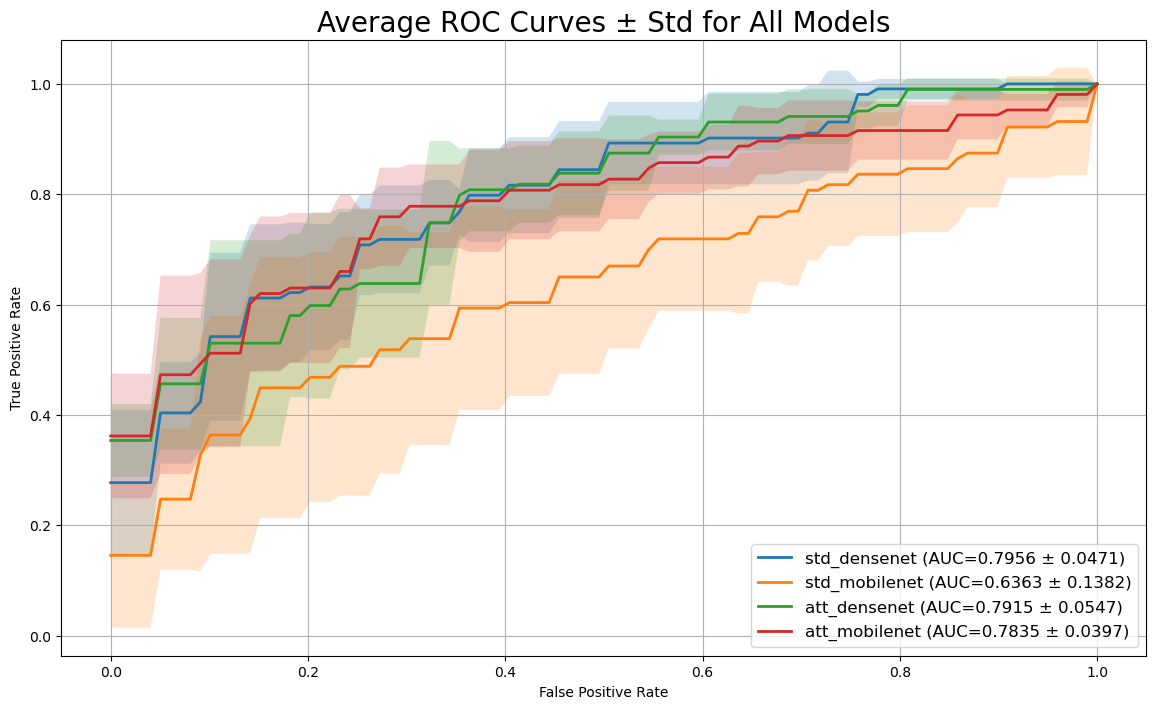

In [14]:
# === Ortalama ROC Curve Çizimi (Tek grafikte) ===
os.makedirs('roc_plots', exist_ok=True)

plt.figure(figsize=(14, 8))

for model_name, fold_results in all_outer_results.items():
    all_fprs = [r['fpr'] for r in fold_results]
    all_tprs = [r['tpr'] for r in fold_results]

    mean_fpr = np.linspace(0, 1, 100)
    interp_tprs = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fprs, all_tprs)]
    mean_tpr = np.mean(interp_tprs, axis=0)
    std_tpr = np.std(interp_tprs, axis=0)
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std([auc(fpr, tpr) for fpr, tpr in zip(all_fprs, all_tprs)])

    plt.plot(mean_fpr, mean_tpr, lw=2,
             label=f'{model_name} (AUC={mean_auc:.4f} ± {std_auc:.4f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2)

plt.title('Average ROC Curves ± Std for All Models', fontsize=20)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.savefig('roc_plots/avg_roc_all_models.png')
plt.show()

In [15]:
# # === Ortalama ROC Curve Çizimi ===
# os.makedirs('roc_plots', exist_ok=True)
# for model_name, fold_results in all_outer_results.items():
#     all_fprs = [r['fpr'] for r in fold_results]
#     all_tprs = [r['tpr'] for r in fold_results]
#     mean_fpr = np.linspace(0, 1, 100)
#     interp_tprs = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fprs, all_tprs)]
#     mean_tpr = np.mean(interp_tprs, axis=0)
#     std_tpr = np.std(interp_tprs, axis=0)
#     mean_auc = auc(mean_fpr, mean_tpr)
#     std_auc = np.std([auc(fpr, tpr) for fpr, tpr in zip(all_fprs, all_tprs)])
#     plt.figure(figsize=(14, 8))
#     plt.plot(mean_fpr, mean_tpr, label=f'{model_name} Mean (AUC={mean_auc:.4f})', lw=2)
#     plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2)
#     plt.title(f'Average ROC Curve ± Std — {model_name}', fontsize=20)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend(loc='lower right')
#     plt.grid(True)
#     plt.savefig(f'roc_plots/avg_roc_{model_name}.png')


In [16]:
all_outer_results['att_densenet']

[{'fold': 1,
  'metrics': {'accuracy': 0.7857142857142857,
   'precision': 0.8095238095238095,
   'recall': 0.7727272727272727,
   'f1': 0.7906976744186046,
   'auc': 0.8613636363636363},
  'confusion_matrix': array([[16,  4],
         [ 5, 17]], dtype=int64),
  'fpr': array([0.  , 0.  , 0.  , 0.05, 0.05, 0.1 , 0.1 , 0.2 , 0.2 , 0.5 , 0.5 ,
         0.6 , 0.6 , 1.  ]),
  'tpr': array([0.        , 0.04545455, 0.40909091, 0.40909091, 0.54545455,
         0.54545455, 0.77272727, 0.77272727, 0.81818182, 0.81818182,
         0.90909091, 0.90909091, 1.        , 1.        ]),
  'labels': [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'preds': [0,
   0,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
  